# Quantum Simulation of Tunneling through an Eckart Barrier

In [ ]:
import numpy as np
from sympy.combinatorics import GrayCode
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library import QFT
from qiskit.extensions import Initialize
from qiskit.quantum_info import Statevector

In [ ]:
#walsh function w_j(x_k) in sequency order
def w(j, k, n):
    j_binary = format(j, f'0{n}b')
    k_dyadic = format(k, f'0{n}b')[::-1]
    exponent = 0 
    for i in range(n):
        exponent += int(j_binary[i])*int(k_dyadic[i])
    return (-1)**exponent

#full array of discrete walsh-fourier transform coefficients a_j
def wft(f, n, x_grid):
    #coefficient a_j in the discrete walsh-fourier transform of f
    def a_j(f, j, n):
        N = 2**n
        a_val = 0 
        for k in range(N):
            a_val += f(x_grid[k])*w(j, k, n)
        return a_val/N
    return np.array([a_j(f, j, n) for j in range(2**n)])

#array of inverse discrete walsh-fourier transform coefficients f_k (keeping terms_kept most significant terms)
def iwft(a, n, terms_kept=None):
    if terms_kept is not None:
        sorted_indices = np.argsort(np.abs(a))[::-1]
        kept_indices = sorted_indices[:terms_kept]
    else:
        kept_indices = list(range(2**n))
    #coefficient f_k in the inverse discrete walsh-fourier transform
    def f_k(a_vals, k, n, kept_indices):
        N = 2**n 
        f_val = 0 
        for j in kept_indices:
            f_val += a_vals[j]*w(j, k, n)
        return f_val
    return np.array([f_k(a, k, n, kept_indices) for k in range(2**n)])

In [ ]:
n = 7
N = 2**n
k_grid = np.arange(0, N, 1)
x_grid = np.linspace(0, 1, N)
repeats = 10
plot_grid = np.arange(1/(2*N*repeats), 1, 1/(N*repeats))
potential = lambda x: 1/np.cosh((x - .5)/(0.5/10))
a = wft(potential, n, x_grid)
approx = iwft(a, n, terms_kept=19)

plt.plot(x_grid, potential(x_grid), label='analytic')
plt.plot(plot_grid, np.repeat(approx, repeats))
plt.show()


In [ ]:
n = 9
N = 2**n
L = 5
k_grid = np.arange(0, N, 1)
x_grid = np.linspace(-5, 5, N)
repeats = 10
plot_grid = np.arange(-L, L, 2*L/(N*repeats))
potential = lambda x: 100/np.cosh(x/.5)
a = wft(potential, n, x_grid)
approx = iwft(a, n, terms_kept=19)
# # create a line plot
plt.plot(x_grid, potential(x_grid), label='analytic')
plt.plot(plot_grid, np.repeat(approx, repeats))
plt.show()


In [ ]:
# Function that gives the partitioned sets by the most significant non-zero bit (MSB) from the number of qubits
def gray_partitions(n):
    # List the Gray code
    g = GrayCode(n)
    gray_list = list(g.generate_gray())[1:]
    
    # Create a dictionary collecting the lists
    partitions = [[] for _ in range(n)]

    # Figure out the MSB and arrange the partiton
    for entry in gray_list:
        index = entry.find('1')
        partitions[n - 1 - index].append(entry)
    return partitions    

# Function that gives the position of the targeted part of the CNOT
def get_control(bitstring1, bitstring2, n):
    xor = ''.join([str(int(bit1) ^ int(bit2)) for bit1, bit2 in zip(bitstring1, bitstring2)])
    return n - 1 - xor.find('1')

In [ ]:
# Function that implements the unitary diagonals
def unitary_circuit(f, n, dt, x_grid, terms_kept=None):
    circ = QuantumCircuit(n)
    a = wft(f, n, x_grid)
    a_kept = np.copy(a)
    if terms_kept is not None:
        sorted_indices = np.argsort(np.abs(a))[::-1]
        dropped_indices = sorted_indices[terms_kept:]
        a_kept[dropped_indices] = 0
    partitions = gray_partitions(n)
    for partition, target in zip(partitions, range(n)):
        if len(partition) == 1: 
            index = eval('0b' + partition[0])
            theta = a_kept[index]
            if np.abs(theta) > 0:
                circ.rz(2*theta*dt, target)
            continue
        for i in range(len(partition)):
            index = eval('0b' + partition[i])
            theta = a_kept[index]
            control = get_control(partition[i - 1], partition[i], n)
            circ.cnot(control, target)
            if np.abs(theta) > 0:
                circ.rz(2*theta*dt, target) 
    circ = transpile(circ, optimization_level=3)
    return circ

# unitary_circuit(potential, 6, dt, x_grid).draw('mpl')

In [ ]:
def trotter_step(n_q, dx, dt):
    """Apply the kinetic term of a single iteration of the Zalka-Wiesner algorithm.
    Args:
        n_q: number of qubits that define the grid.
        d: limits of the grid, i.e., x is defined in [-d, d).
        dt: duration of each discrete time step.

    Returns:
        qc: quantum circuit right after this step.
    """
    qc = QuantumCircuit(n_q)
    N = 2**n_q

    p_vals = (2 * np.pi * np.fft.fftfreq(N, d=dx))[[2**k for k in range(n_q)]]
    p_sum = sum(p_vals)

    for j in range(n_q):
        alpha_j = -(dt / 2) * p_vals[j] ** 2 - (dt / 2) * p_vals[j] * (p_sum - p_vals[j])
        qc.rz(alpha_j, j)

    for j in range(n_q):
        for l in range(j + 1, n_q):
                gamma_jl = (dt / 2) * p_vals[j] * p_vals[l]
                qc.cx(j, l)
                qc.rz(gamma_jl, l)
                qc.cx(j, l)
    return qc

In [ ]:
# Constants
hbar = 1.0  # Reduced Planck's constant
m = 1.0     # Mass of the particle
x0 = -3.0  # Initial position
p0 = 15.0  # Initial momentum
sigma = 0.5
L = 5    # Spatial domain [-L, L]
n = 8  # Number of qubits 
terms_kept = 30 # Number of Walsh functions
N = 2**n   # Number of spatial grid points
T = .6   # Length of the temporal domain
K = 100   # Number of temporal grid points

x_grid = np.linspace(-L, L, N)
t_grid = np.linspace(0, T, K)
dx, dt = x_grid[1] - x_grid[0], t_grid[1] - t_grid[0]

# Define the potential energy
potential = lambda x: 100/np.cosh(x/.5)

def initial_wave_function(x, x0, sigma, p0):
    return np.exp(-(x - x0)**2 / (2 * sigma**2) + 1j*p0*(x - x0))

In [10]:
# Initializing the quantum circuit
qc = QuantumCircuit(n)

# Initialize the initial wave function
desired_vector = initial_wave_function(x_grid, x0, sigma, p0)
wave_func = desired_vector/np.linalg.norm(desired_vector)

# Initialize(params = wave_func)
qc.prepare_state(state=wave_func)

potential_step = unitary_circuit(potential, n, dt, x_grid, terms_kept=terms_kept)
kinetic_step = trotter_step(n, dx, dt)

iqft = QFT(num_qubits=n, inverse=True).to_gate()
qft = QFT(num_qubits=n).to_gate()

states = []
progress = tqdm(total=K)
for i in range(K):
    # Gives the potential energy
    qc.append(potential_step, qargs=[i for i in range(n)][::-1])

    # Apply the inverse QFT                
    qc.append(iqft, qargs=[i for i in range(n)])

    # Gives the kinetic energy
    qc.append(kinetic_step, qargs=[i for i in range(n)])

    # Apply the QFT                
    qc.append(qft, qargs=[i for i in range(n)])
    
    progress.update(1)
    states.append(Statevector.from_instruction(qc))
progress.close()
amplitudes = np.abs(np.array(states))**2

100%|██████████| 100/100 [19:23<00:00, 11.63s/it]


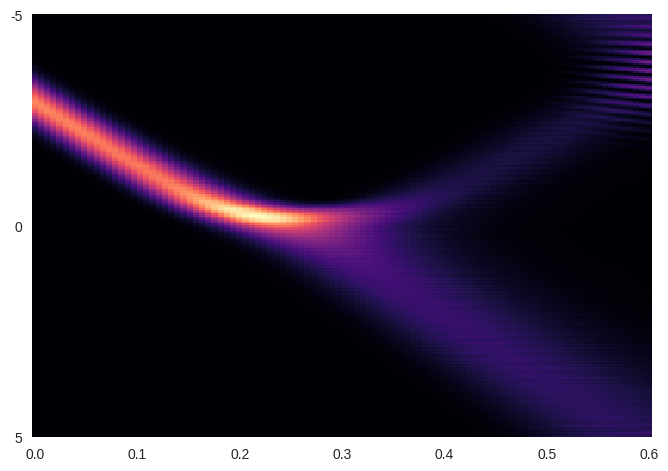

In [11]:
T, X = np.meshgrid(t_grid, x_grid)
C = amplitudes.T
plt.pcolor(T, -X, C, cmap='magma')
plt.yticks([-5, 0, 5], [5, 0, -5])
plt.show()